In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import seaborn as sns

import time, random, requests
from bs4 import BeautifulSoup

import ast
from pathlib import Path

In [2]:
eda        = pd.read_csv("CLEAN_EDA_dataset.csv")          # stock transactions
cong_sec   = pd.read_csv("congress_with_sectors_eda.csv")  # congress-person + sector list
tickers_txt = Path("tickers_dictionary.txt").read_text()

ticker_sectors = ast.literal_eval(tickers_txt)             # dict:  {'AAPL:US': 'Technology', ...}
eda.head()

politician_name    ticker    buy_date   sell_date  days_held  buy_price  \
0     Ashley Moody    HWM:US  2025-01-22  2025-02-24         33     126.71   
1  Bruce Westerman   AAPL:US  2025-03-03  2025-03-20         17     238.03   
2  Bruce Westerman   AMZN:US  2025-03-03  2025-03-20         17     205.02   
3  Bruce Westerman   AVGO:US  2025-03-03  2025-03-20         17     187.37   
4  Bruce Westerman  GOOGL:US  2025-03-03  2025-03-20         17     167.01   

   sell_price  size_buy size_sell  pct_return  
0      129.56  50K–100K  50K–100K    2.249231  
1      214.10   15K–50K    1K–15K  -10.053355  
2      194.95   15K–50K    1K–15K   -4.911716  
3      190.54    1K–15K    1K–15K    1.691840  
4      162.80   15K–50K    1K–15K   -2.520807

In [3]:
# HELPER: maps any ticker format to sector (This could be useful still for final project)
def lookup_sector(raw_ticker: str) -> str | None:
    """
    Accepts tickers formatted like
        'AAPL'   | 'AAPL:US' | '$AAPL' | '$AAPL:US'
    and returns the sector string from ticker_sectors
    (or None if we can't find / it’s an ETF/None in dict).
    """
    if pd.isna(raw_ticker):
        return None
    
    # strip $, whitespace, anything after the first ':'
    key_core = raw_ticker.replace("$", "").strip().split(":")[0].upper()

    # brute-force match against dict keys
    for k, sector in ticker_sectors.items():
        if k.split(":")[0].upper() == key_core:
            return sector          # may itself be None for ETFs
    return None


In [4]:
# STOCK SECTOR TIME
eda["stock_sector"] = eda["ticker"].apply(lookup_sector)

In [5]:
eda.head()

politician_name    ticker    buy_date   sell_date  days_held  buy_price  \
0     Ashley Moody    HWM:US  2025-01-22  2025-02-24         33     126.71   
1  Bruce Westerman   AAPL:US  2025-03-03  2025-03-20         17     238.03   
2  Bruce Westerman   AMZN:US  2025-03-03  2025-03-20         17     205.02   
3  Bruce Westerman   AVGO:US  2025-03-03  2025-03-20         17     187.37   
4  Bruce Westerman  GOOGL:US  2025-03-03  2025-03-20         17     167.01   

   sell_price  size_buy size_sell  pct_return            stock_sector  
0      129.56  50K–100K  50K–100K    2.249231             Industrials  
1      214.10   15K–50K    1K–15K  -10.053355              Technology  
2      194.95   15K–50K    1K–15K   -4.911716  Consumer Discretionary  
3      190.54    1K–15K    1K–15K    1.691840              Technology  
4      162.80   15K–50K    1K–15K   -2.520807  Communication Services

In [6]:
# Congress-side sector column (**NOTE: I thought it was already a good python list form before?? Is this necessary?)
#  - file already has a list-like string, e.g.  "['Energy', 'Transportation']"
#  - safely turn that into an actual Python list
cong_sec["politician_sectors"] = cong_sec["sectors"].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else [])

In [7]:
cong_sec.head()

politician_name                                          committee  \
0     Abigail Spanberger                 ["Agriculture", "Foreign Affairs"]   
1  April McClain Delaney  ["Agriculture", "Science, Space, and Technology"]   
2           Ashley Moody  ["Health, Education, Labor, and Pensions", "Ho...   
3         August Pfluger  ["Homeland Security", "Foreign Affairs", "Ener...   
4           Bill Keating              ["Armed Services", "Foreign Affairs"]   

                               sectors               politician_sectors  
0  ['Consumer Staples', 'Industrials']  [Consumer Staples, Industrials]  
1   ['Consumer Staples', 'Technology']   [Consumer Staples, Technology]  
2        ['Healthcare', 'Industrials']        [Healthcare, Industrials]  
3            ['Energy', 'Industrials']            [Energy, Industrials]  
4                      ['Industrials']                    [Industrials]

In [8]:
# Merge stock rows with the matching congress-person
merged = eda.merge(
    cong_sec[["politician_name", "politician_sectors"]],        # drop the committees column
    left_on="politician_name",                                  # column in CLEAN_EDA_dataset
    right_on="politician_name",
    how="left"
)

In [9]:
merged.head()

politician_name    ticker    buy_date   sell_date  days_held  buy_price  \
0     Ashley Moody    HWM:US  2025-01-22  2025-02-24         33     126.71   
1  Bruce Westerman   AAPL:US  2025-03-03  2025-03-20         17     238.03   
2  Bruce Westerman   AMZN:US  2025-03-03  2025-03-20         17     205.02   
3  Bruce Westerman   AVGO:US  2025-03-03  2025-03-20         17     187.37   
4  Bruce Westerman  GOOGL:US  2025-03-03  2025-03-20         17     167.01   

   sell_price  size_buy size_sell  pct_return            stock_sector  \
0      129.56  50K–100K  50K–100K    2.249231             Industrials   
1      214.10   15K–50K    1K–15K  -10.053355              Technology   
2      194.95   15K–50K    1K–15K   -4.911716  Consumer Discretionary   
3      190.54    1K–15K    1K–15K    1.691840              Technology   
4      162.80   15K–50K    1K–15K   -2.520807  Communication Services   

          politician_sectors  
0  [Healthcare, Industrials]  
1  [Financials, Industrials]  
2  [Financials, Industrials]  
3  [Financials, Industrials]  
4  [Financials, Industrials]

In [10]:
# related BOOLEAN --> “does ANY politician sector match stock sector?”
def related_flag(row) -> int:
    stock_sector = row["stock_sector"]
    pol_sectors  = row["politician_sectors"]
    if (stock_sector is None) or (not pol_sectors):
        return 0
    return int(stock_sector in pol_sectors)

merged["trade_related"] = merged.apply(related_flag, axis=1)

In [11]:
merged.head()

politician_name    ticker    buy_date   sell_date  days_held  buy_price  \
0     Ashley Moody    HWM:US  2025-01-22  2025-02-24         33     126.71   
1  Bruce Westerman   AAPL:US  2025-03-03  2025-03-20         17     238.03   
2  Bruce Westerman   AMZN:US  2025-03-03  2025-03-20         17     205.02   
3  Bruce Westerman   AVGO:US  2025-03-03  2025-03-20         17     187.37   
4  Bruce Westerman  GOOGL:US  2025-03-03  2025-03-20         17     167.01   

   sell_price  size_buy size_sell  pct_return            stock_sector  \
0      129.56  50K–100K  50K–100K    2.249231             Industrials   
1      214.10   15K–50K    1K–15K  -10.053355              Technology   
2      194.95   15K–50K    1K–15K   -4.911716  Consumer Discretionary   
3      190.54    1K–15K    1K–15K    1.691840              Technology   
4      162.80   15K–50K    1K–15K   -2.520807  Communication Services   

          politician_sectors  trade_related  
0  [Healthcare, Industrials]              1  
1  [Financials, Industrials]              0  
2  [Financials, Industrials]              0  
3  [Financials, Industrials]              0  
4  [Financials, Industrials]              0

In [12]:
merged.describe()

days_held     buy_price    sell_price   pct_return  trade_related
count  1164.000000   1164.000000   1164.000000  1164.000000    1164.000000
mean     88.772337    289.809639    279.315309    -1.256891       0.146048
std      75.152311   2786.645148   2765.210747    32.826053       0.353306
min       1.000000      0.140000      0.100000   -89.293878       0.000000
25%      32.000000     65.682500     62.485000    -9.795836       0.000000
50%      66.000000    126.070000    121.165000    -2.697453       0.000000
75%     141.000000    241.785000    238.497500     4.217471       0.000000
max     302.000000  94686.200000  93943.800000   915.384615       1.000000

In [13]:
merged.to_csv("TEST_MERGED1.csv", index=False)

In [23]:
merged['trade_related'].value_counts()

trade_related
0    994
1    170
Name: count, dtype: int64

In [31]:
merged['stock_sector'].value_counts()

stock_sector
Technology                248
Healthcare                182
Financials                153
Industrials               144
Consumer Discretionary    131
Consumer Staples           99
Communication Services     58
Materials                  51
Real Estate                39
Energy                     21
Sector not found           12
Utilities                   9
Name: count, dtype: int64

In [37]:
exploded_df = cong_sec.explode('politician_sectors')
unique_pairs = exploded_df[['politician_name', 'politician_sectors']].drop_duplicates()
sector_counts = unique_pairs['politician_sectors'].value_counts()
print(sector_counts)

politician_sectors
Industrials               71
Financials                48
Healthcare                20
Energy                    16
Consumer Discretionary    12
Consumer Staples          10
Materials                  7
Utilities                  6
Technology                 5
Name: count, dtype: int64


In [38]:
merged['size_buy'].value_counts()

size_buy
1K–15K       883
15K–50K      206
50K–100K      54
100K–250K     18
250K–500K      2
1M–5M          1
Name: count, dtype: int64

In [39]:
merged['size_sell'].value_counts()

size_sell
1K–15K       884
15K–50K      201
50K–100K      52
100K–250K     22
250K–500K      2
< 1K           2
1M–5M          1
Name: count, dtype: int64

In [24]:
df_related = merged[merged['trade_related'] == True]
df_unrelated = merged[merged['trade_related'] == False]

In [26]:
df_related.describe()

days_held    buy_price   sell_price  pct_return  trade_related
count  170.000000   170.000000   170.000000  170.000000          170.0
mean    87.182353   249.406294   246.104941   -0.113102            1.0
std     70.139816   265.938495   239.977683   15.764711            0.0
min      1.000000    10.120000     9.470000  -44.433546            1.0
25%     33.000000   102.955000   101.790000   -7.146468            1.0
50%     64.000000   203.020000   195.100000   -2.496911            1.0
75%    134.750000   333.887500   338.990000    4.684249            1.0
max    267.000000  2231.140000  1842.960000   80.293605            1.0

In [27]:
df_unrelated.describe()

days_held     buy_price    sell_price  pct_return  trade_related
count  994.000000    994.000000    994.000000  994.000000          994.0
mean    89.044266    296.719668    284.995151   -1.452509            0.0
std     76.006559   3013.710319   2990.889148   34.920843            0.0
min      1.000000      0.140000      0.100000  -89.293878            0.0
25%     32.000000     61.647500     59.072500  -10.087719            0.0
50%     66.000000    115.585000    112.790000   -2.770104            0.0
75%    141.000000    222.377500    222.247500    4.127361            0.0
max    302.000000  94686.200000  93943.800000  915.384615            0.0

In [30]:
filtered_df_unrelated = df_unrelated[df_unrelated['pct_return'] <= 200]
filtered_df_unrelated.describe()

days_held     buy_price    sell_price  pct_return  trade_related
count  992.000000    992.000000    992.000000  992.000000          992.0
mean    88.935484    297.213125    285.017913   -2.649437            0.0
std     76.044399   3016.729551   2993.905546   17.274967            0.0
min      1.000000      0.140000      0.100000  -89.293878            0.0
25%     32.000000     61.682500     58.970000  -10.099928            0.0
50%     66.000000    115.905000    112.490000   -2.777667            0.0
75%    141.000000    222.767500    221.257500    4.104517            0.0
max    302.000000  94686.200000  93943.800000  105.947137            0.0

([<matplotlib.axis.XTick at 0x7f1cc819c190>,
 [Text(0, 0, 'Unrelated'), Text(1, 0, 'Related')])

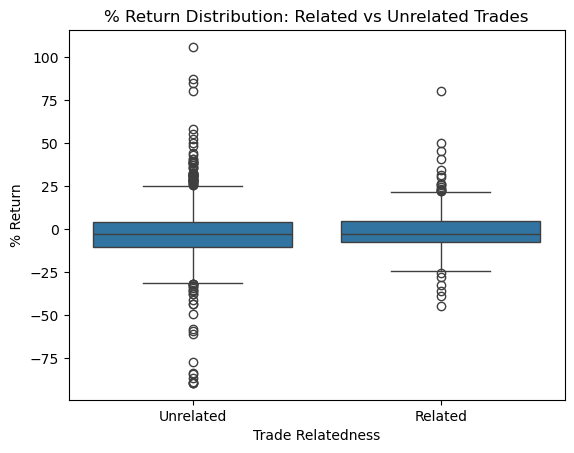

In [18]:
filtered_df = merged[merged['pct_return'] <= 200]

sns.boxplot(x='trade_related', y='pct_return', data=filtered_df)
plt.title('% Return Distribution: Related vs Unrelated Trades')
plt.xlabel('Trade Relatedness')
plt.ylabel('% Return')
plt.xticks([0, 1], ['Unrelated', 'Related'])

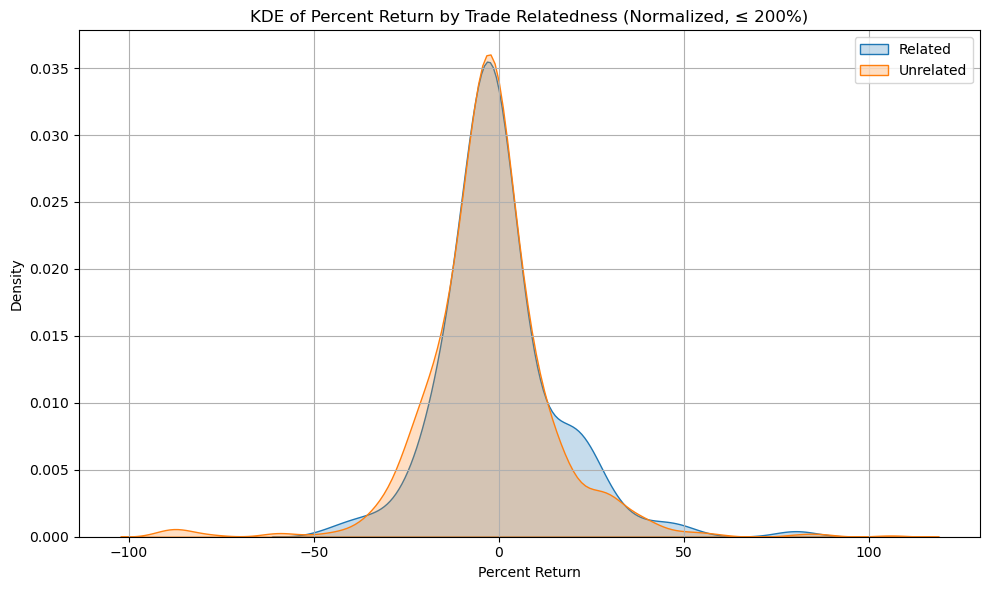

In [21]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot KDE separately to normalize each group
sns.kdeplot(data=filtered_df[filtered_df['trade_related'] == 1], x='pct_return', label='Related', fill=True, common_norm=False)
sns.kdeplot(data=filtered_df[filtered_df['trade_related'] == 0], x='pct_return', label='Unrelated', fill=True, common_norm=False)

plt.title('KDE of Percent Return by Trade Relatedness (Normalized, ≤ 200%)')
plt.xlabel('Percent Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

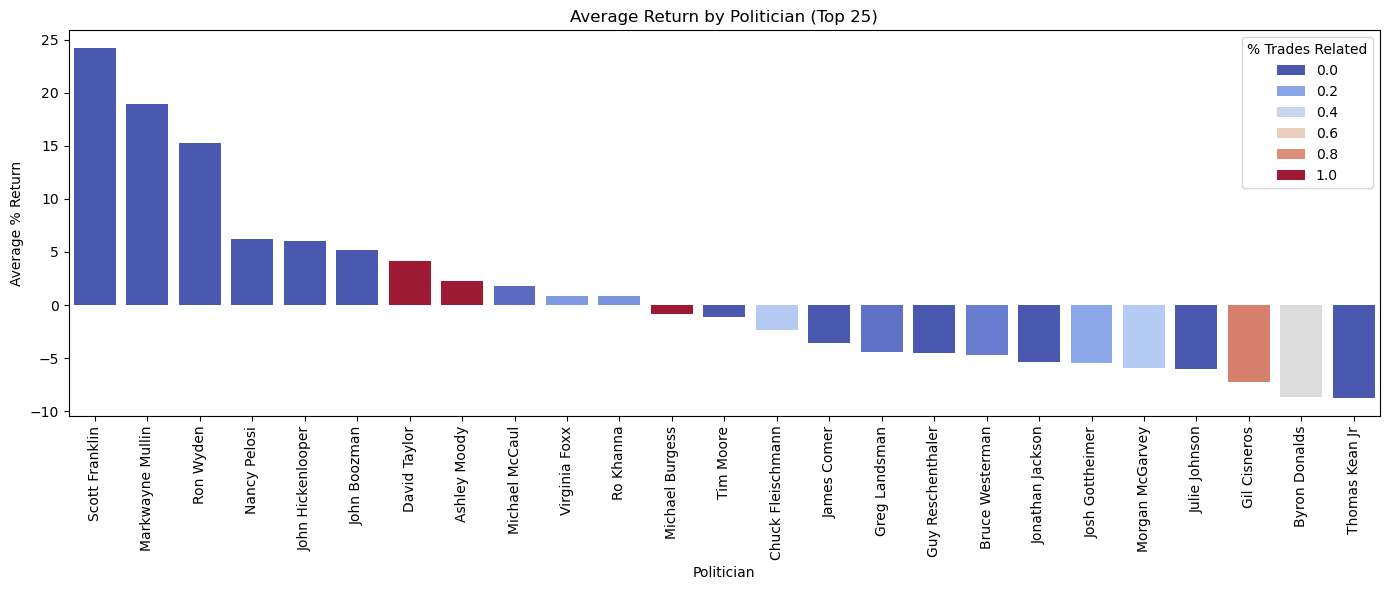

In [48]:
# Group by politician, compute average return and % of related trades
grouped = merged.groupby('politician_name').agg(
    avg_return=('pct_return', 'mean'),
    std_return=('pct_return', 'std'),
    count=('pct_return', 'count'),
    proportion_related=('trade_related', 'mean')
).reset_index()

# Optional: sort by return or proportion_related
grouped = grouped.sort_values('avg_return', ascending=False).head(25)

# Bar plot with error bars (std / sqrt(n))
plt.figure(figsize=(14, 6))
sns.barplot(
    data=grouped,
    x='politician_name',
    y='avg_return',
    hue='proportion_related',
    dodge=False,
    palette='coolwarm',
    errorbar=('ci', 95)
)
plt.xticks(rotation=90)
plt.title('Average Return by Politician (Top 25)')
plt.ylabel('Average % Return')
plt.xlabel('Politician')
plt.legend(title='% Trades Related')
plt.tight_layout()
plt.show()

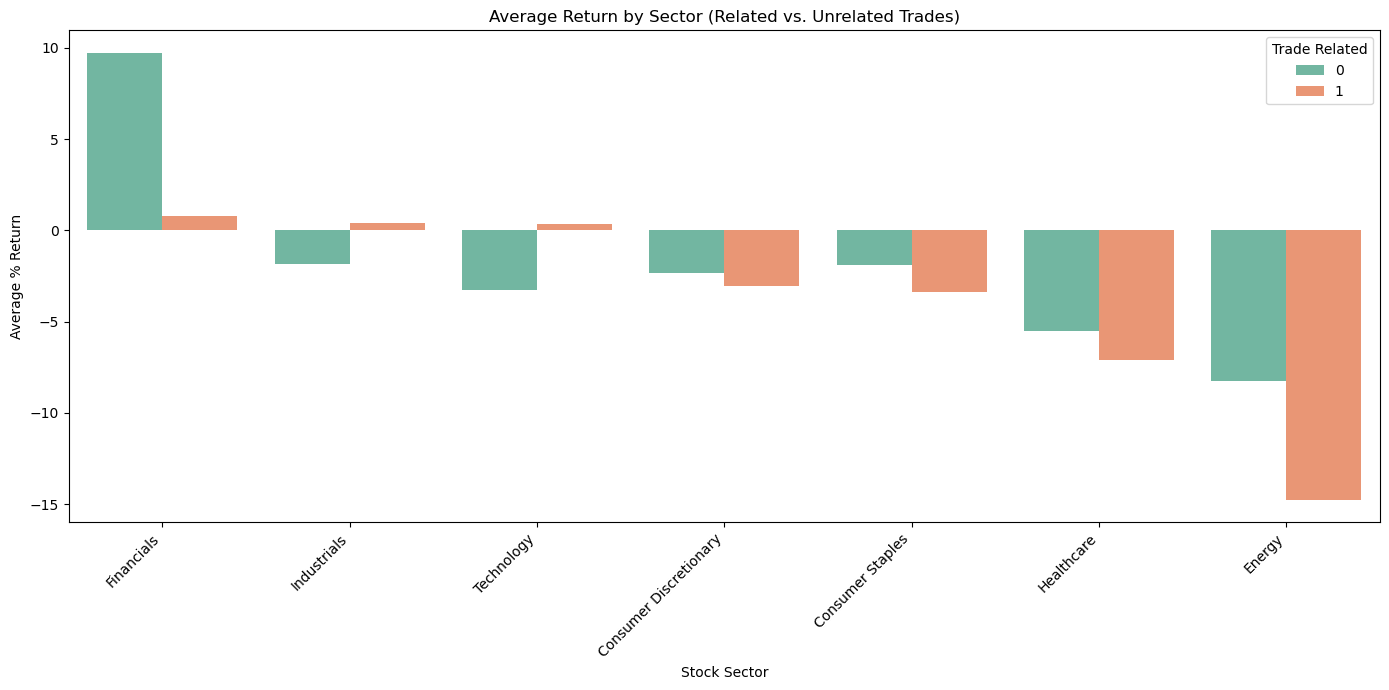

In [50]:
# Group by stock_sector and trade_related
sector_grouped = merged.groupby(['stock_sector', 'trade_related']).agg(
    avg_return=('pct_return', 'mean'),
    std_return=('pct_return', 'std'),
    count=('pct_return', 'count')
).reset_index()

# Sort sectors by average return when trade_related == 1 (if you want that order)
related_order = (
    sector_grouped[sector_grouped['trade_related'] == 1]
    .sort_values('avg_return', ascending=False)['stock_sector']
)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(
    data=sector_grouped,
    x='stock_sector',
    y='avg_return',
    hue='trade_related',
    order=related_order,
    palette='Set2'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Stock Sector')
plt.ylabel('Average % Return')
plt.title('Average Return by Sector (Related vs. Unrelated Trades)')
plt.legend(title='Trade Related')
plt.tight_layout()
plt.show()

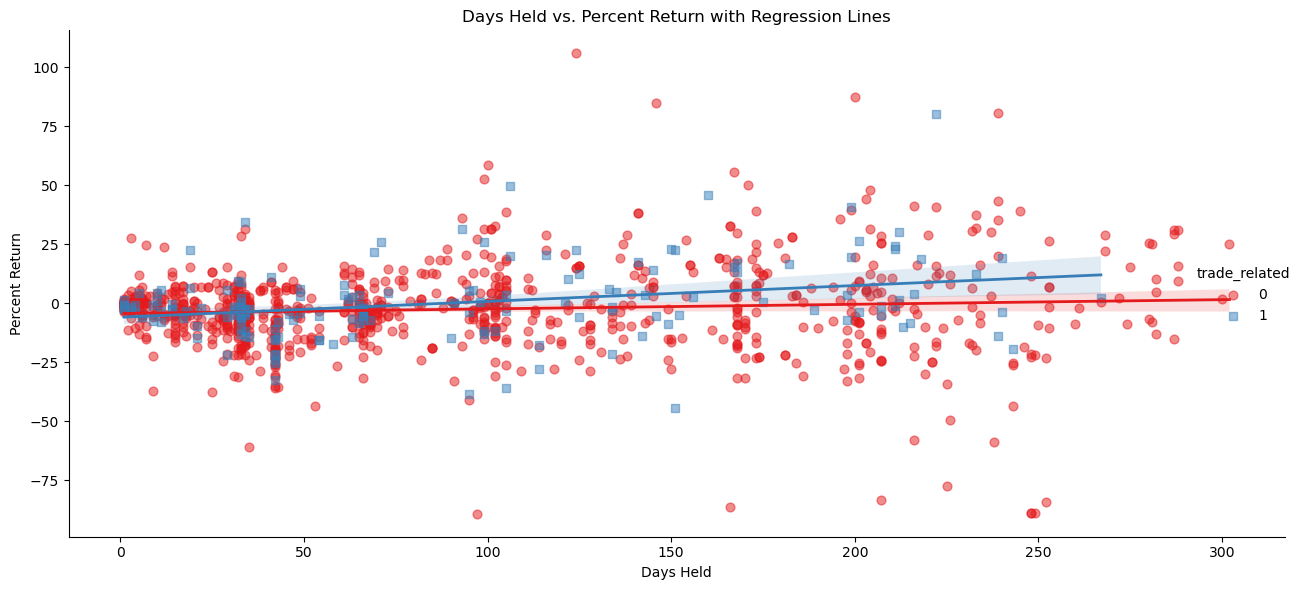

In [54]:
sns.lmplot(
    data=filtered_df,
    x='days_held',
    y='pct_return',
    hue='trade_related',
    scatter_kws={'s': 40, 'alpha': 0.5},
    line_kws={'linewidth': 2},
    height=6,
    aspect=2,
    palette='Set1',
    markers=['o', 's']  # Optional: different markers for related/unrelated
)

plt.title("Days Held vs. Percent Return with Regression Lines")
plt.xlabel("Days Held")
plt.ylabel("Percent Return")
plt.tight_layout()
plt.show()

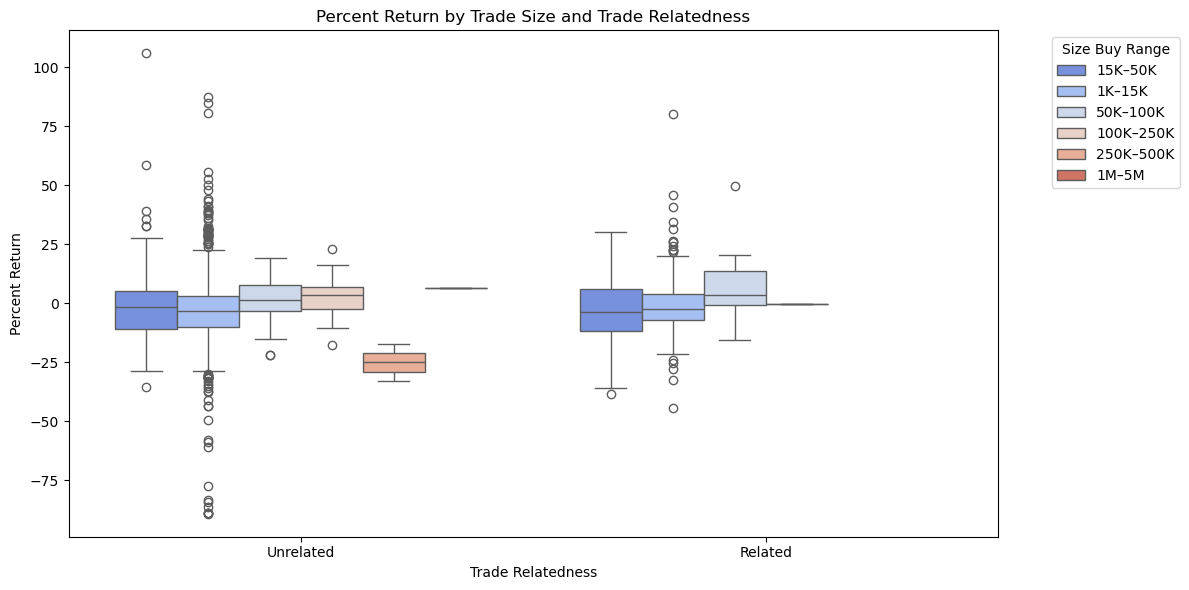

In [61]:
size_buy_avg_map = {
    '1K–15K': 8000,
    '15K–50K': 32500,
    '50K–100K': 75000,
    '100K–250K': 175000,
    '250K–500K': 375000,
    '500K–1M': 750000,
    '1M–5M': 3000000,
    '5M–25M': 15000000,
    '25M–50M': 37500000
}

# Copy the df and map average sizes
plot_df = filtered_df.copy()
plot_df['log_size_buy'] = (
    plot_df['size_buy']
    .map(size_buy_avg_map)
    .apply(lambda x: np.log10(x) if pd.notnull(x) else np.nan)
)

# Preserve the original size_buy labels for the hue
plot_df['size_buy_label'] = plot_df['size_buy']

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=plot_df,
    x='trade_related',
    y='pct_return',
    hue='size_buy_label',  # Use original labels for legend
    palette='coolwarm',
    dodge=True
)

plt.title("Percent Return by Trade Size and Trade Relatedness")
plt.xlabel("Trade Relatedness")
plt.xticks([0, 1], ['Unrelated', 'Related'])
plt.ylabel("Percent Return")
plt.legend(title="Size Buy Range", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()